# Interpretability

- Data load and preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

dfFeature = pd.read_csv(r'pruebaData.csv')
dfFeature.drop(columns=['Complain'], inplace= True)

X = dfFeature.drop('Exited', axis=1)
y = dfFeature['Exited']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

c:\Users\dekum\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INTRINSICALLY INTERPRETABLE MODELS:

First, we are going to analyze the interpretability of some classification models we have used, which are Logistic Regression and Decision Trees. The objective is to determine which of the variables have more impact in the outcome 

- Logistic Regression

In [2]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga","sag"])
    C = trial.suggest_float("C", 1e-6, 1e2, log =True)
    max_iter = trial.suggest_int('max_iter', 100, 5000)
    model = LogisticRegression(
        solver=solver,
        C=C,
        random_state=42,
        class_weight='balanced',
        max_iter= max_iter
    )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=500, n_jobs=-1)
print("Best hyperparameters:", study.best_params)

[I 2024-12-21 21:00:36,404] A new study created in memory with name: no-name-1ef549da-a539-4a82-ad79-562d145a07d4
[I 2024-12-21 21:00:38,734] Trial 10 finished with value: 0.7937041923895561 and parameters: {'solver': 'sag', 'C': 0.0003136244302557949, 'max_iter': 2097}. Best is trial 10 with value: 0.7937041923895561.
[I 2024-12-21 21:00:38,740] Trial 1 finished with value: 0.7886406757134188 and parameters: {'solver': 'liblinear', 'C': 7.196404253395728e-06, 'max_iter': 1094}. Best is trial 10 with value: 0.7937041923895561.
[I 2024-12-21 21:00:38,761] Trial 5 finished with value: 0.788403270699502 and parameters: {'solver': 'sag', 'C': 1.2612791784714344e-06, 'max_iter': 4551}. Best is trial 10 with value: 0.7937041923895561.
[I 2024-12-21 21:00:38,771] Trial 6 finished with value: 0.7889657231462666 and parameters: {'solver': 'sag', 'C': 1.6869410144003437e-05, 'max_iter': 703}. Best is trial 10 with value: 0.7937041923895561.
[I 2024-12-21 21:00:38,775] Trial 2 finished with value

Best hyperparameters: {'solver': 'lbfgs', 'C': 0.036290392615935974, 'max_iter': 3016}


In [3]:
best_params = study.best_params
logistic_model = LogisticRegression(
    solver=best_params["solver"],
    C=best_params["C"],
    random_state=42,
    class_weight='balanced',
    max_iter=best_params["max_iter"]
)

logistic_model.fit(X_train_scaled, y_train)
logistic_score = logistic_model.score(X_test_scaled, y_test)
logistic_score

0.736

In [4]:
coefs_log = logistic_model.coef_
intercept_log = logistic_model.intercept_
print('coefficients: %s' % coefs_log)
print('intercept: %s' % intercept_log)

coefficients: [[-0.07057972 -0.01177525  0.07196488 -0.42595651 -0.01849335 -0.40953032
   0.03843376 -0.01575943 -0.05113768  0.14347223 -0.14347223 -0.14567574
   0.26040011 -0.09282285  0.03093422 -0.02262986 -0.00611748 -0.00194395
  -0.29899732  0.26827333  0.4767555  -0.37235564  0.15400635]]
intercept: [-0.37800129]


In [5]:
# Feature Importance
coef_df = pd.DataFrame({'feature': X_train.columns.values, 'coef': coefs_log[0]})
coef_df

,feature,coef
0,CreditScore,-0.070580
1,Tenure,-0.011775
2,Balance,0.071965
3,NumOfProducts,-0.425957
4,HasCrCard,-0.018493
5,IsActiveMember,-0.409530
6,EstimatedSalary,0.038434
7,Satisfaction Score,-0.015759
8,Point Earned,-0.051138
9,Gender_Female,0.143472


In [6]:
#Standardized
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(23,) * stdv).sort_values(ascending=False)

Balance               4483.720951
EstimatedSalary       2207.062147
Point Earned            11.560249
CreditScore              6.824357
NumOfProducts            0.212949
IsActiveMember           0.204652
Age_30-40                0.148302
Age_<30                  0.138169
Age_50-60                0.134454
Age_40-50                0.117286
Geography_Germany        0.112944
Geography_France         0.072838
Gender_Male              0.071396
Gender_Female            0.071396
Geography_Spain          0.040106
Age_>60                  0.034732
Tenure                   0.034034
Satisfaction Score       0.022225
Card Type_DIAMOND        0.013348
Card Type_GOLD           0.009860
HasCrCard                0.008413
Card Type_PLATINUM       0.002648
Card Type_SILVER         0.000840
dtype: float64

- Decision Tree

In [7]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 32)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 32)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        class_weight="balanced", 
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best hyperparameters:", study.best_params)

[I 2024-12-21 21:00:54,417] A new study created in memory with name: no-name-a3673231-3119-4f05-bc6c-97bb5e7ab1e7
[I 2024-12-21 21:00:54,744] Trial 1 finished with value: 0.7076747310533464 and parameters: {'n_estimators': 991, 'max_depth': 33, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.7076747310533464.
[I 2024-12-21 21:00:54,783] Trial 0 finished with value: 0.769461432520153 and parameters: {'n_estimators': 925, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 25, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.769461432520153.
[I 2024-12-21 21:00:54,791] Trial 11 finished with value: 0.7513668846490933 and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 25, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.769461432520153.
[I 2024-12-21 21:00:54,805] Trial 8 finished with value: 0.7644708709344993 and parameters: {'n_estimators': 969, 'max_depth': 45, 

Best hyperparameters: {'n_estimators': 287, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 16, 'max_features': 'sqrt'}


In [8]:
best_params = study.best_params

decision_tree = DecisionTreeClassifier(
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42,
    class_weight="balanced",
)
decision_tree.fit(X_train, y_train)
decision_tree.score(X_test, y_test)

0.741

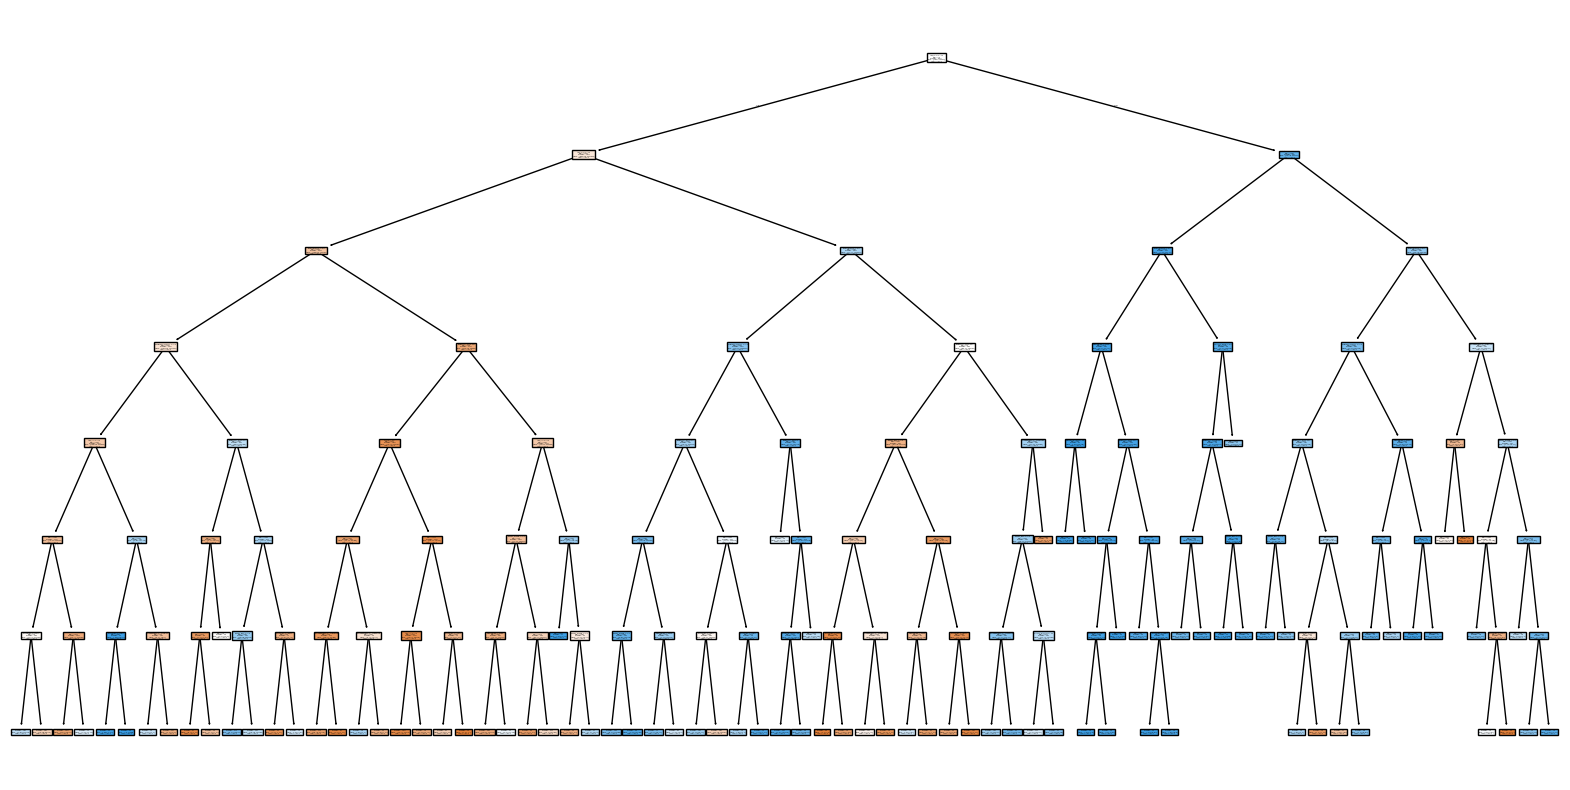

In [9]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=X.columns, class_names=['Class 0', 'Class 1'])
plt.show()

In [10]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),
'importance': decision_tree.feature_importances_}).sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
20,Age_50-60,0.207074
2,Balance,0.199368
19,Age_40-50,0.190017
3,NumOfProducts,0.107588
5,IsActiveMember,0.069854
12,Geography_Germany,0.058248
22,Age_>60,0.044411
6,EstimatedSalary,0.032499
0,CreditScore,0.030040
1,Tenure,0.016724


Now we will interprate the results given by both models:

    Logistic Regression:

 -Most possitively influential variables:  'Age_50-60' (0.47), 'Age_40-50' (0.26) and 'Geography_Germany' (0.26)

 -Most negatively influential variables: NumOfProducts (-0.42), 'IsActiveMember'(-0.41) and 'Age_<30' (-0.37)

 -Most influential standardized variables: 'Balance' (4483.72) and 'EstimatedSalary' (2207.06)

The logistic regression model (73,6%) indicates that age and geography, as well as the balance and the estimated salary are really important for the model's predictions.

We can see that age categories follow a clear pattern, the old customers with higher balance, have the highest chance to exit on the outcome, while the young and inactive customer is the least likely to exit.

Also, If we compare 'Gender_Female' (0.14) and 'Gender_Male' (-0.14), we can se that male customers have a negative influence and females are possitively influential in this case, showing that females are more likely to exit and males to stay. Also, German people seem to be specially predisposed to exiting banks. 

The negative intercept (-0.37) means that if there is no influence, customers are less likely to exit. But this is not relevant in out case because variables like age are practically never 0.

    Decision Tree

The decision tree model suggests that it's most important features are 'Age_50-60' (0.20), 'Balance' (0.19), 'Age_40-50' (0.19) and 'NumOfProducts' (0.10). The rest have low or 0 relevance. In conclussion, the decision tree model supports our logistic regression model's conclussions which are the most important factors.

GLOBAL MODEL AGNOSTIC METHODS

The second step is to understand which is the way our models work, for that we are going to use PDP and ALE:

- Partial Dependence Plot